In [1]:
!pip install pytorch-tabnet
!pip install torch

Defaulting to user installation because normal site-packages is not writeable


Defaulting to user installation because normal site-packages is not writeable


## Imports and UDFs

In [3]:
import pandas as pd 
import numpy as np
import sklearn
import pickle
import matplotlib.pyplot as plt
import lazypredict
import xgboost as xgb
import eli5

from skopt import BayesSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import ExtraTreesClassifier, StackingClassifier, BaggingClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, accuracy_score, make_scorer
from sklearn.model_selection import train_test_split, GridSearchCV, RepeatedStratifiedKFold, RandomizedSearchCV, cross_val_score

from lazypredict.Supervised import LazyClassifier
import lightgbm as lgb
from catboost import CatBoostClassifier
import optuna

from pytorch_tabnet.tab_model import TabNetClassifier
import torch

In [4]:
def make_submission(preds):
    assert len(preds) == 5000
    
    # Read labels
    with open('test_labels_sorted.npy', 'rb') as f:
        test_labels = np.load(f)
    len(test_labels)
    
    submission = pd.DataFrame(columns=['id', 'class'])
    for label, pred in zip(test_labels, preds):
        submission = submission.append({'id': label, 'class': pred}, ignore_index=True)
    return submission

In [5]:
def plot_confusion_matrix(y_val_from_train, y_pred_from_train):
    fig, ax = plt.subplots(figsize=(8, 5))
    cmp = ConfusionMatrixDisplay(confusion_matrix(y_val_from_train, y_pred_from_train))
    cmp.plot(ax=ax)
    plt.show();

## Load data and split (try 64 features)

In [6]:
# Load X_train
with open('X_train_64_std.npy', 'rb') as f:
    X_train = np.load(f)
print(X_train.shape)
X_train

(9000, 64)


array([[ 0.66868409,  0.16353656,  0.63277468, ..., -0.68600237,
        -0.75071056, -0.6719989 ],
       [ 0.37202545,  0.27579237,  0.65904756, ...,  0.06479231,
        -0.48439794,  0.56611352],
       [-1.67047552, -1.2187742 , -2.37040642, ..., -0.65838631,
        -0.38095167, -0.1542973 ],
       ...,
       [-0.24270722, -0.14209669, -0.32285351, ...,  0.37591901,
        -0.37936549,  0.58761686],
       [ 0.38630325,  0.31266521,  0.37767149, ...,  0.83458681,
         0.3138927 ,  0.79569199],
       [ 0.33077964, -0.0822815 , -0.51143673, ..., -1.1650511 ,
        -0.410986  ,  0.44873132]])

In [7]:
# Load y_train
with open('y_train.npy', 'rb') as f:
    y_train = np.load(f)
print(y_train.shape)
y_train

(9000,)


array([ 7, 13,  6, ...,  3,  3, 18], dtype=int64)

In [8]:
# Load X_test
with open('X_test_64_std.npy', 'rb') as f:
    X_test = np.load(f)
print(X_test.shape)
X_test

(5000, 64)


array([[-0.59806336,  0.6264903 , -0.15256881, ...,  1.17376188,
         0.23880484,  0.48877589],
       [-0.47352949,  0.94441404, -0.23499654, ..., -0.41222519,
        -0.40989637, -0.65814035],
       [-0.64168924, -1.56209892, -1.06875674, ...,  0.3385773 ,
        -0.56342902,  0.74796695],
       ...,
       [ 1.00103725, -0.3371114 ,  0.37115316, ..., -1.16055904,
        -0.46010399, -0.62722221],
       [-0.98752639, -1.20156778, -1.41423994, ..., -0.81406819,
        -0.78249592,  1.12406601],
       [-0.21177287, -0.85742305, -0.54931118, ...,  0.02750228,
        -0.76809252, -1.25225668]])

In [26]:
# Create validation data
# Train/test sets
X_train_from_train, X_val_from_train, y_train_from_train, y_val_from_train = train_test_split(
    X_train, y_train, test_size=0.15, random_state=42
)

## Try TabNet

In [46]:
tabnet = TabNetClassifier(optimizer_params=dict(lr=2e-2), scheduler_params={"step_size":10, "gamma":0.9}, scheduler_fn=torch.optim.lr_scheduler.StepLR)

In [47]:
tabnet.fit(
    X_train_from_train, y_train_from_train,
    eval_set=[(X_train_from_train, y_train_from_train), (X_val_from_train, y_val_from_train)],
    eval_name=['train', 'val'],
    eval_metric=['accuracy'],
    max_epochs=300,
    batch_size=128,
    num_workers=0,
    weights=1,
    drop_last=False,
    patience=-1
)            

epoch 0  | loss: 2.72381 | train_accuracy: 0.26131 | val_accuracy: 0.28148 |  0:00:00s
epoch 1  | loss: 1.3007  | train_accuracy: 0.54366 | val_accuracy: 0.55111 |  0:00:01s
epoch 2  | loss: 0.72235 | train_accuracy: 0.73686 | val_accuracy: 0.75185 |  0:00:02s
epoch 3  | loss: 0.60005 | train_accuracy: 0.81137 | val_accuracy: 0.82222 |  0:00:02s
epoch 4  | loss: 0.54474 | train_accuracy: 0.82575 | val_accuracy: 0.83704 |  0:00:03s
epoch 5  | loss: 0.47813 | train_accuracy: 0.86353 | val_accuracy: 0.85852 |  0:00:04s
epoch 6  | loss: 0.424   | train_accuracy: 0.85542 | val_accuracy: 0.85259 |  0:00:04s
epoch 7  | loss: 0.43784 | train_accuracy: 0.84941 | val_accuracy: 0.85481 |  0:00:05s
epoch 8  | loss: 0.41197 | train_accuracy: 0.8502  | val_accuracy: 0.86    |  0:00:06s
epoch 9  | loss: 0.41395 | train_accuracy: 0.86732 | val_accuracy: 0.87556 |  0:00:06s
epoch 10 | loss: 0.36601 | train_accuracy: 0.89346 | val_accuracy: 0.89037 |  0:00:07s
epoch 11 | loss: 0.3554  | train_accuracy: 

epoch 95 | loss: 0.10937 | train_accuracy: 0.97595 | val_accuracy: 0.94222 |  0:01:06s
epoch 96 | loss: 0.11356 | train_accuracy: 0.98222 | val_accuracy: 0.94593 |  0:01:06s
epoch 97 | loss: 0.09131 | train_accuracy: 0.97987 | val_accuracy: 0.94519 |  0:01:07s
epoch 98 | loss: 0.10967 | train_accuracy: 0.97529 | val_accuracy: 0.94444 |  0:01:08s
epoch 99 | loss: 0.11145 | train_accuracy: 0.97882 | val_accuracy: 0.94148 |  0:01:09s
epoch 100| loss: 0.11158 | train_accuracy: 0.98222 | val_accuracy: 0.94593 |  0:01:09s
epoch 101| loss: 0.10097 | train_accuracy: 0.98157 | val_accuracy: 0.94    |  0:01:10s
epoch 102| loss: 0.09669 | train_accuracy: 0.97974 | val_accuracy: 0.94741 |  0:01:11s
epoch 103| loss: 0.09156 | train_accuracy: 0.98327 | val_accuracy: 0.9437  |  0:01:11s
epoch 104| loss: 0.09091 | train_accuracy: 0.98458 | val_accuracy: 0.94889 |  0:01:12s
epoch 105| loss: 0.09736 | train_accuracy: 0.98026 | val_accuracy: 0.94074 |  0:01:13s
epoch 106| loss: 0.10374 | train_accuracy: 

epoch 190| loss: 0.05984 | train_accuracy: 0.99425 | val_accuracy: 0.94667 |  0:02:12s
epoch 191| loss: 0.05178 | train_accuracy: 0.99542 | val_accuracy: 0.9437  |  0:02:12s
epoch 192| loss: 0.05152 | train_accuracy: 0.99333 | val_accuracy: 0.9437  |  0:02:13s
epoch 193| loss: 0.05879 | train_accuracy: 0.99542 | val_accuracy: 0.94444 |  0:02:14s
epoch 194| loss: 0.05783 | train_accuracy: 0.99464 | val_accuracy: 0.94741 |  0:02:14s
epoch 195| loss: 0.05099 | train_accuracy: 0.99542 | val_accuracy: 0.94593 |  0:02:15s
epoch 196| loss: 0.05975 | train_accuracy: 0.99294 | val_accuracy: 0.95111 |  0:02:16s
epoch 197| loss: 0.05967 | train_accuracy: 0.99386 | val_accuracy: 0.94222 |  0:02:16s
epoch 198| loss: 0.05405 | train_accuracy: 0.99294 | val_accuracy: 0.94519 |  0:02:17s
epoch 199| loss: 0.04789 | train_accuracy: 0.99542 | val_accuracy: 0.94519 |  0:02:18s
epoch 200| loss: 0.0464  | train_accuracy: 0.9949  | val_accuracy: 0.9437  |  0:02:19s
epoch 201| loss: 0.05533 | train_accuracy: 

epoch 285| loss: 0.03757 | train_accuracy: 0.9983  | val_accuracy: 0.94741 |  0:03:18s
epoch 286| loss: 0.03887 | train_accuracy: 0.99817 | val_accuracy: 0.95111 |  0:03:19s
epoch 287| loss: 0.03477 | train_accuracy: 0.99804 | val_accuracy: 0.95037 |  0:03:19s
epoch 288| loss: 0.03977 | train_accuracy: 0.9983  | val_accuracy: 0.94889 |  0:03:20s
epoch 289| loss: 0.03965 | train_accuracy: 0.99804 | val_accuracy: 0.95111 |  0:03:21s
epoch 290| loss: 0.03753 | train_accuracy: 0.99804 | val_accuracy: 0.95185 |  0:03:21s
epoch 291| loss: 0.03679 | train_accuracy: 0.99791 | val_accuracy: 0.95259 |  0:03:22s
epoch 292| loss: 0.03986 | train_accuracy: 0.99869 | val_accuracy: 0.94889 |  0:03:23s
epoch 293| loss: 0.0433  | train_accuracy: 0.99817 | val_accuracy: 0.95037 |  0:03:24s
epoch 294| loss: 0.04072 | train_accuracy: 0.99817 | val_accuracy: 0.94889 |  0:03:24s
epoch 295| loss: 0.03999 | train_accuracy: 0.9983  | val_accuracy: 0.95111 |  0:03:25s
epoch 296| loss: 0.03916 | train_accuracy: 

In [48]:
# Validation predict
y_pred_from_train = tabnet.predict(X_val_from_train)

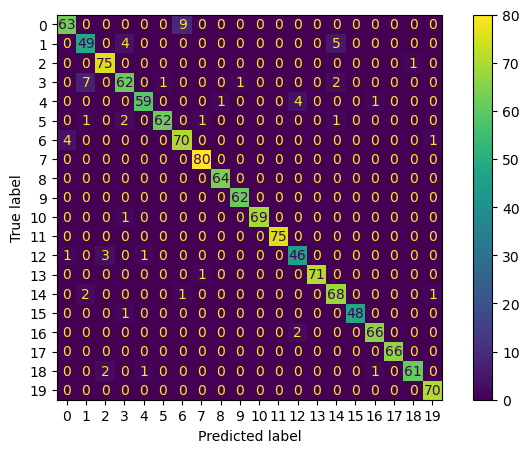

In [49]:
# Plot Confusion Matrix
plot_confusion_matrix(y_val_from_train, y_pred_from_train)

In [50]:
accuracy_score(y_val_from_train, y_pred_from_train) # 95.25% 300 epochs, 128 batch size

0.9525925925925925

### Re-train using full data

In [56]:
tabnet = TabNetClassifier(optimizer_params=dict(lr=2e-2), scheduler_params={"step_size":10, "gamma":0.9}, scheduler_fn=torch.optim.lr_scheduler.StepLR)

In [57]:
tabnet.fit(
    X_train_from_train, y_train_from_train,
    eval_set=[(X_train_from_train, y_train_from_train)],
    eval_name=['train'],
    eval_metric=['accuracy'],
    max_epochs=300,
    batch_size=128,
    num_workers=0,
    weights=1,
    drop_last=False,
    patience=-1
)  

epoch 0  | loss: 2.72381 | train_accuracy: 0.26131 |  0:00:00s
epoch 1  | loss: 1.31511 | train_accuracy: 0.53752 |  0:00:01s
epoch 2  | loss: 0.71923 | train_accuracy: 0.74039 |  0:00:02s
epoch 3  | loss: 0.5842  | train_accuracy: 0.78967 |  0:00:02s
epoch 4  | loss: 0.54002 | train_accuracy: 0.81085 |  0:00:03s
epoch 5  | loss: 0.45803 | train_accuracy: 0.87255 |  0:00:04s
epoch 6  | loss: 0.41114 | train_accuracy: 0.87451 |  0:00:04s
epoch 7  | loss: 0.44115 | train_accuracy: 0.83451 |  0:00:05s
epoch 8  | loss: 0.38908 | train_accuracy: 0.87673 |  0:00:06s
epoch 9  | loss: 0.39404 | train_accuracy: 0.87333 |  0:00:06s
epoch 10 | loss: 0.33815 | train_accuracy: 0.88863 |  0:00:07s
epoch 11 | loss: 0.3377  | train_accuracy: 0.87725 |  0:00:08s
epoch 12 | loss: 0.36064 | train_accuracy: 0.88458 |  0:00:08s
epoch 13 | loss: 0.31797 | train_accuracy: 0.90431 |  0:00:09s
epoch 14 | loss: 0.30887 | train_accuracy: 0.90458 |  0:00:10s
epoch 15 | loss: 0.30776 | train_accuracy: 0.89333 |  0

epoch 131| loss: 0.08883 | train_accuracy: 0.98039 |  0:01:28s
epoch 132| loss: 0.08792 | train_accuracy: 0.98732 |  0:01:28s
epoch 133| loss: 0.07987 | train_accuracy: 0.98261 |  0:01:29s
epoch 134| loss: 0.08325 | train_accuracy: 0.98797 |  0:01:30s
epoch 135| loss: 0.08634 | train_accuracy: 0.98562 |  0:01:30s
epoch 136| loss: 0.08567 | train_accuracy: 0.98627 |  0:01:31s
epoch 137| loss: 0.08737 | train_accuracy: 0.98784 |  0:01:31s
epoch 138| loss: 0.08203 | train_accuracy: 0.9885  |  0:01:32s
epoch 139| loss: 0.0839  | train_accuracy: 0.98824 |  0:01:33s
epoch 140| loss: 0.07841 | train_accuracy: 0.98837 |  0:01:33s
epoch 141| loss: 0.07509 | train_accuracy: 0.98784 |  0:01:34s
epoch 142| loss: 0.07914 | train_accuracy: 0.98824 |  0:01:35s
epoch 143| loss: 0.07907 | train_accuracy: 0.98758 |  0:01:35s
epoch 144| loss: 0.07958 | train_accuracy: 0.98614 |  0:01:36s
epoch 145| loss: 0.0778  | train_accuracy: 0.98484 |  0:01:37s
epoch 146| loss: 0.08269 | train_accuracy: 0.98458 |  0

epoch 262| loss: 0.05123 | train_accuracy: 0.99503 |  0:02:52s
epoch 263| loss: 0.05646 | train_accuracy: 0.99569 |  0:02:53s
epoch 264| loss: 0.0497  | train_accuracy: 0.99569 |  0:02:54s
epoch 265| loss: 0.05914 | train_accuracy: 0.99556 |  0:02:54s
epoch 266| loss: 0.04906 | train_accuracy: 0.99608 |  0:02:55s
epoch 267| loss: 0.04836 | train_accuracy: 0.99621 |  0:02:55s
epoch 268| loss: 0.03698 | train_accuracy: 0.99542 |  0:02:56s
epoch 269| loss: 0.04573 | train_accuracy: 0.99634 |  0:02:57s
epoch 270| loss: 0.04692 | train_accuracy: 0.99621 |  0:02:57s
epoch 271| loss: 0.04597 | train_accuracy: 0.99569 |  0:02:58s
epoch 272| loss: 0.04724 | train_accuracy: 0.9949  |  0:02:59s
epoch 273| loss: 0.05246 | train_accuracy: 0.99621 |  0:02:59s
epoch 274| loss: 0.04501 | train_accuracy: 0.99529 |  0:03:00s
epoch 275| loss: 0.04944 | train_accuracy: 0.99569 |  0:03:01s
epoch 276| loss: 0.03985 | train_accuracy: 0.99608 |  0:03:01s
epoch 277| loss: 0.04717 | train_accuracy: 0.99608 |  0

### Make predictions

In [58]:
preds = tabnet.predict(X_test)

In [59]:
preds

array([3, 4, 5, ..., 2, 5, 1], dtype=int64)

In [60]:
submission = make_submission(preds)
submission

,id,class
0,10001,3
1,10002,4
2,10004,5
3,10008,20
4,10009,1
...,...,...
4995,23986,19
4996,23991,12
4997,23992,2
4998,23998,5


In [61]:
submission.to_csv('submission_tabnet_epochs300_bs128_64f.csv', index=False)

## TODO: Try Hyperparam tuning with Optuna for TabNet

In [ ]:
tabnet = TabNetClassifier(optimizer_params=dict(lr=2e-2), scheduler_params={"step_size":10, "gamma":0.9}, scheduler_fn=torch.optim.lr_scheduler.StepLR)

In [ ]:
def get_objective(X_train, y_train, X_valid, y_valid):
    def objective(trial):
        hyperparams = {
            
        }
        model = TabNetClassifier(optimizer_params=dict(lr=2e-2), 
                                 scheduler_params={"step_size":10, "gamma":0.9}, 
                                 scheduler_fn=torch.optim.lr_scheduler.StepLR)
        model.fit(X_train, y_train)
        y_pred_from_train = model.predict(X_valid)
        score = accuracy_score(y_valid, y_pred_from_train)
        
        return score
    return objective